# Pantheon

In [2]:
plt.rcParams.update({'font.size': 25})
plt.style.use("dark_background")

https://github.com/dscolnic/Pantheon/blob/master/lcparam_full_long.txt

In [1]:
# packages
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as opt
import matplotlib.pyplot as plt
import csv

In [3]:
# constant
c = 2.99792458 * 1e5 # units: km/s

In [40]:
redshift

array([0.50349, 0.4952 , 0.6782 , ..., 1.014  , 1.315  , 1.092  ])

In [82]:
# read redshift and luminosity distance data from file
data_pan = np.genfromtxt('lcparam_full_long_zhel.txt')
redshift = data_pan.T[1] #cmb
dist_mod = data_pan.T[4]*2 #pc
dist_mod_err = data_pan.T[5] #pc
lum_dist = 10**((dist_mod - 25)/5)
lum_dist_err = lum_dist * np.log(10) * dist_mod_err/5

In [83]:
lum_dist

array([ 14920.38398127,  14193.18945822,  41217.34372578, ...,
        87454.06480627, 164793.47052047,  71670.428332  ])

In [84]:
def D_L(z, omega_m, omega_lambda, H_0):
    omega_k = 1-omega_m-omega_lambda
    if (omega_k == 0): # handle this case separately to avoid division by zero errors
        def integrand(x):
            return 1/np.sqrt((1+x)**2*(1+omega_m*x) - x*(2+x)*omega_lambda)
        integral = integrate.quad(integrand,0,z)[0]
        r = c*integral/H_0
        return (1+z)*r
        
    prefactor = (c/H_0) * (1+z) * (1/np.sqrt(np.abs(omega_k)))
    def integrand(x):
        return 1/np.sqrt((1+x)**2 * (1+omega_m*x) - x * (2+x) * omega_lambda)
    integral = integrate.quad(integrand,0,z)[0]
    arg = np.sqrt(np.abs(omega_k)) * integral
    sinn = np.sin(arg) if omega_k <= 0 else np.sinh(arg)
    return prefactor * sinn

## Fitting Model to Data
To solve for the cosmological parameters, we will fit our luminosity distance and redshift data to the function ``D_L()`` using SciPy's curve_fit function.

In [85]:
def D_L_helper(redshifts, omega_m, omega_lambda, H_0):
    return [D_L(z,omega_m,omega_lambda,H_0) for z in redshifts]

In [86]:
bnds = ((0,0,60),(2,2,80))
popt, pcov = opt.curve_fit(D_L_helper, redshift, lum_dist, p0=[0.3,0.7,70], bounds = bnds, sigma = lum_dist_err)
omega_m, omega_lambda, H_0 = popt
omega_m_err, omega_lambda_err, H_0_err = np.sqrt(np.diag(pcov))

In [87]:
print("Matter density: ", "{0:.3f}".format(omega_m), " ± ", "{0:.3f}".format(omega_m_err))
print("Dark energy density: ", "{0:.2f}".format(omega_lambda), " ± ", "{0:.2f}".format(omega_lambda_err))
print("Hubble constant: ", "{0:.2f}".format(H_0), " ± ", "{0:.2f}".format(H_0_err))

Matter density:  2.000  ±  16.570
Dark energy density:  0.00  ±  12.37
Hubble constant:  80.00  ±  4.43


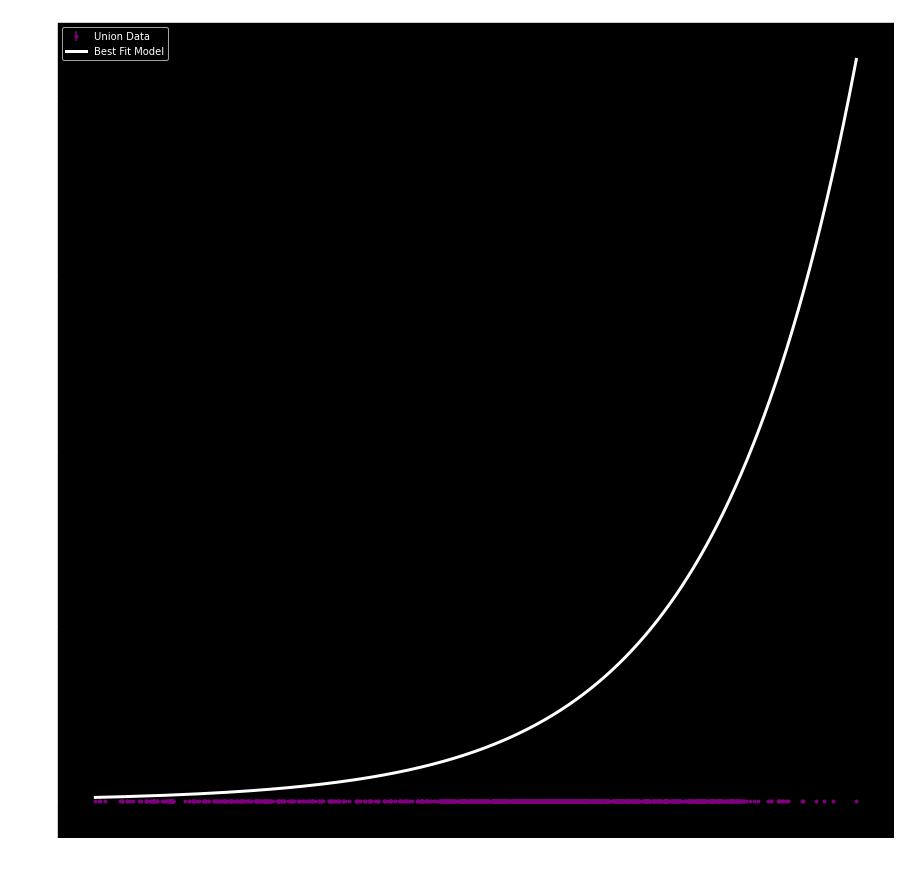

In [64]:
plt.figure(figsize = (15,15))
zz = np.linspace(np.min(redshift),np.max(redshift),1000)
plt.errorbar(np.log(redshift),lum_dist,yerr=lum_dist_err,fmt='.',color='purple')
plt.errorbar(np.log(zz),D_L_helper(zz, omega_m, omega_lambda, H_0), linewidth=3,color='white')
plt.xlabel("$\log(z)$")
plt.ylabel("$D_L$ (Mpc)")
plt.legend(("Union Data","Best Fit Model"),loc='upper left')
plt.title("Union Data Modeled by Curve Fitting");

Possibly add zoomed-in version of plot at high redshift?

## Phase Space Sampling
An alternative method for finding the best fit values of the cosmological parameters is to uniformly sample the phase space and identify which combination of parameters provides the best fit to the data. We will sample from the following ranges for the cosmological parameters.
$$ \Omega_{m,0} \in [0,1], \quad \Omega_{\Lambda,0} \in [0,1], \quad H_0 \in [60,80]$$

To evaluate the goodness of fit for each possible combination of parameters, we will compute the chi-squared statistic, which is defined by
$$\chi^2 = \sum_i \frac{(d_{obs,i}-d_{exp,i})^2}{d_{err,i}^2}$$

where the observed luminosity distances are $d_{obs,i}\pm d_{err,i}$, the expected luminosity distances (based on our choice of cosmological parameters) are $d_{exp,i}$, and the sum is taken over all data points.

In [66]:
num_points = 20

omega_m_range = np.linspace(0,1.5,num_points)
omega_lambda_range = np.linspace(0,1.5,num_points)

H_0_range = np.linspace(60,80,num_points)

omega_m_best = omega_m_range[0]
omega_lambda_best = omega_lambda_range[0]
H_0_best = H_0_range[0]
expected = D_L_helper(redshift, omega_m, omega_lambda, H_0)
chi2_best = np.sum((lum_dist - expected)**2/lum_dist_err**2)
k_best = 0


chi2_arr = np.zeros((num_points,num_points,num_points))
new_array = np.zeros((num_points,num_points))

for k in np.arange(np.size(H_0_range)):
    for i in np.arange(np.size(omega_m_range)):
        for j in np.arange(np.size(omega_lambda_range)):
                omega_m = omega_m_range[i]
                omega_lambda = omega_lambda_range[j]
                H_0 = H_0_range[k]
                expected = D_L_helper(redshift, omega_m, omega_lambda, H_0)
                chi2 = np.sum((lum_dist - expected)**2/lum_dist_err**2)
                chi2_arr[i][j][k] = chi2
                new_array[i][j] = chi2
                if chi2 < chi2_best:
                    omega_m_best = omega_m
                    omega_lambda_best = omega_lambda
                    H_0_best = H_0
                    chi2_best = chi2
                    k_best = k
                
print("Matter density: ", "{0:.2f}".format(omega_m_best))
print("Dark energy density: ", "{0:.2f}".format(omega_lambda_best))
print("Hubble constant: ", "{0:.2f}".format(H_0_best))

<ipython-input-60-f655e3600710>:12: RuntimeWarning: invalid value encountered in sqrt
  return 1/np.sqrt((1+x)**2 * (1+omega_m*x) - x * (2+x) * omega_lambda)
<ipython-input-60-f655e3600710>:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = integrate.quad(integrand,0,z)[0]


Matter density:  1.50
Dark energy density:  0.00
Hubble constant:  80.00


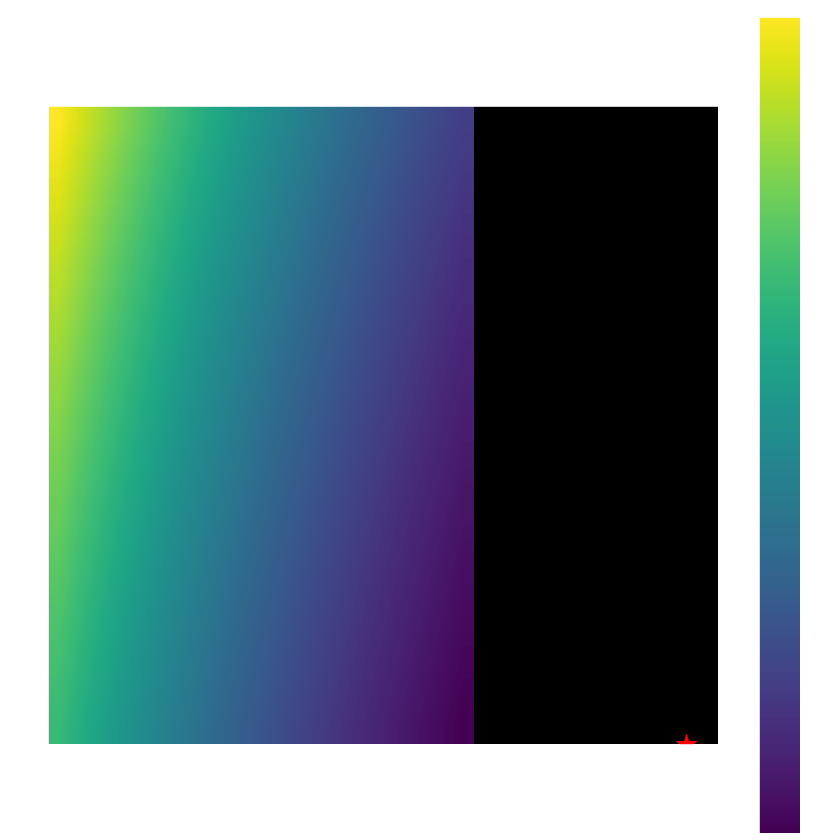

In [70]:
chi2_slice = chi2_arr[:][:][k_best]
plt.figure(figsize = (15,15))
im = plt.imshow(chi2_slice, interpolation='bilinear', origin='lower', \
                cmap='viridis', extent=(0.,1.0,0.,1.5))
plt.colorbar()
#plt.plot(X[am],Y[am],'r*',markersize=20)
plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title('Brute Force Reduced Chi-Square-Fit (SCP Data)')
plt.plot(omega_m_best,omega_lambda_best,'r*',markersize=20)
plt.show()


In [145]:
from astropy.cosmology import FlatLambdaCDM as magic

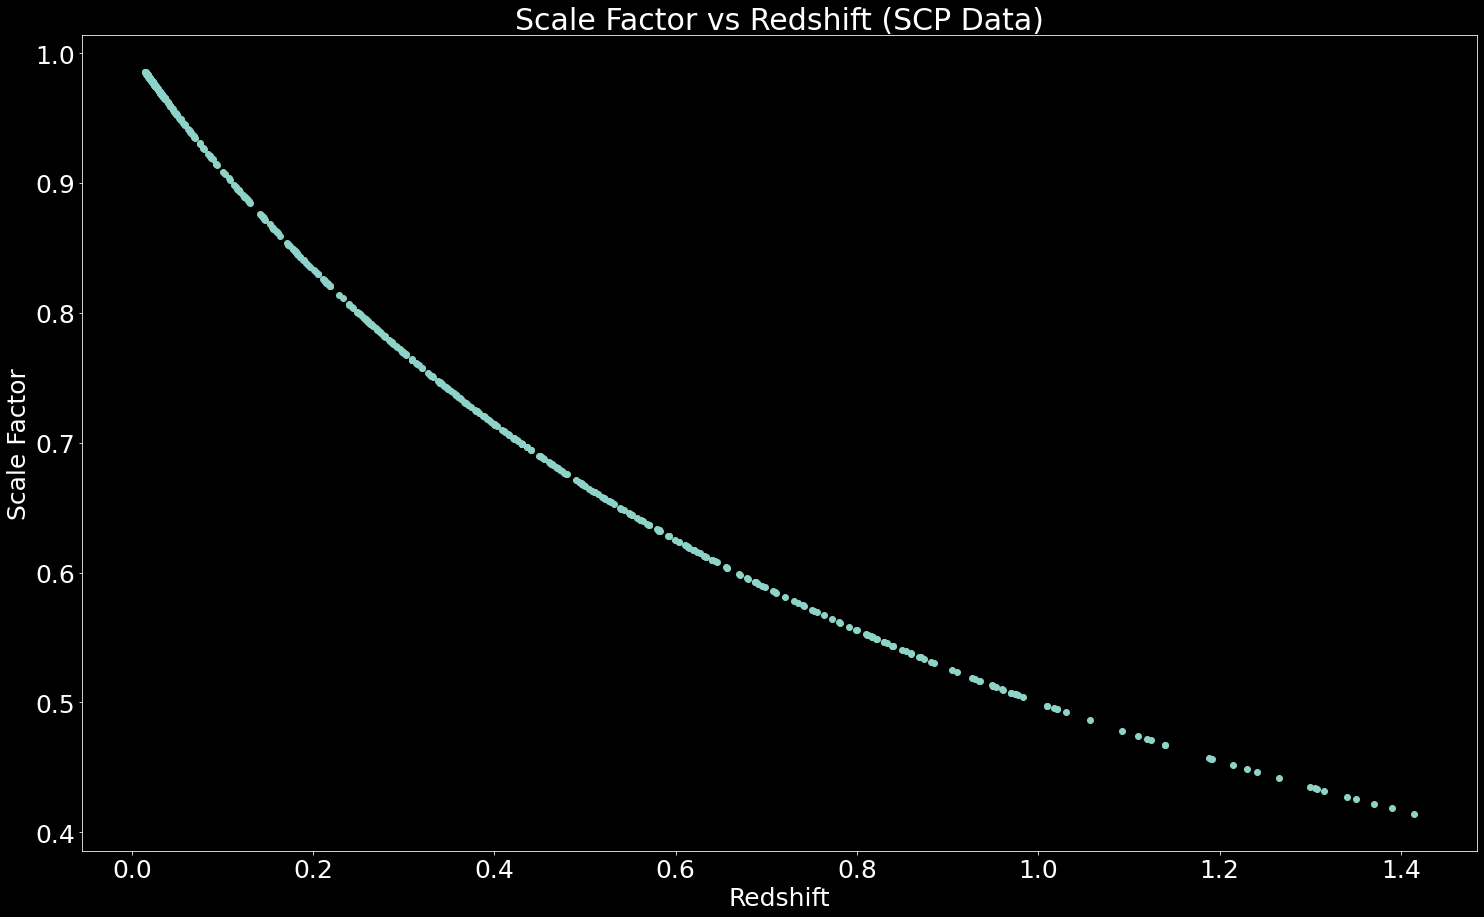

In [146]:
cosmo = magic(H0=H_0_best, Om0=omega_m_best)
plt.figure(figsize = (25,15))
scale_factor = cosmo.scale_factor(redshift)
plt.scatter(redshift, scale_factor)
plt.xlabel('Redshift')
plt.ylabel('Scale Factor')
plt.title('Scale Factor vs Redshift (SCP Data)')
plt.show()

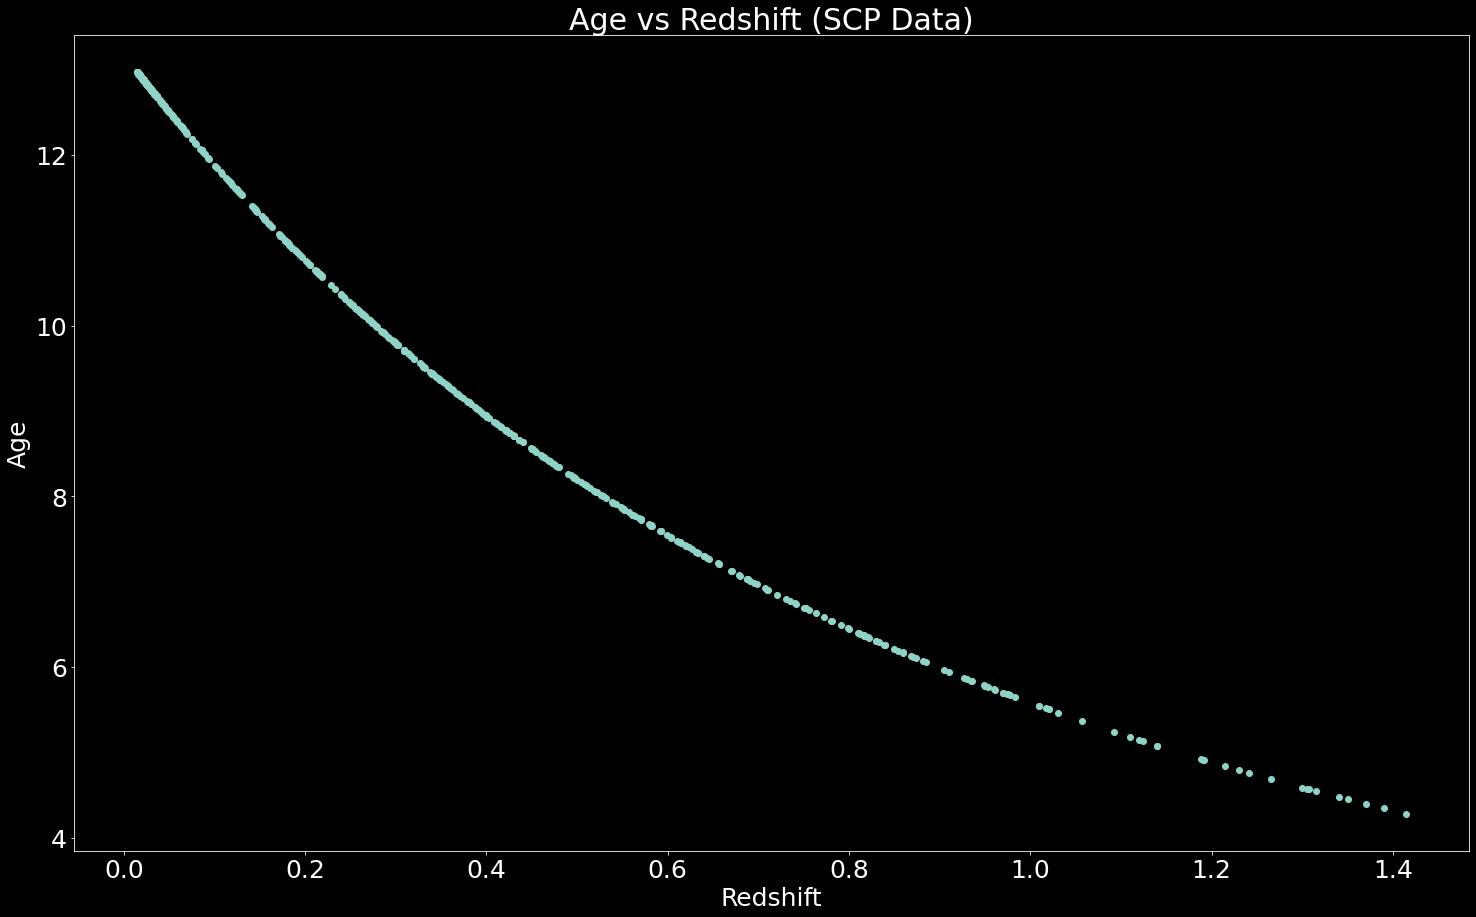

In [147]:
cosmo = magic(H0=H_0_best, Om0=omega_m_best)
plt.figure(figsize = (25,15))
scale_factor = cosmo.age(redshift)
plt.scatter(redshift, scale_factor)
plt.xlabel('Redshift')
plt.ylabel('Age')
plt.title('Age vs Redshift (SCP Data)')
plt.show()

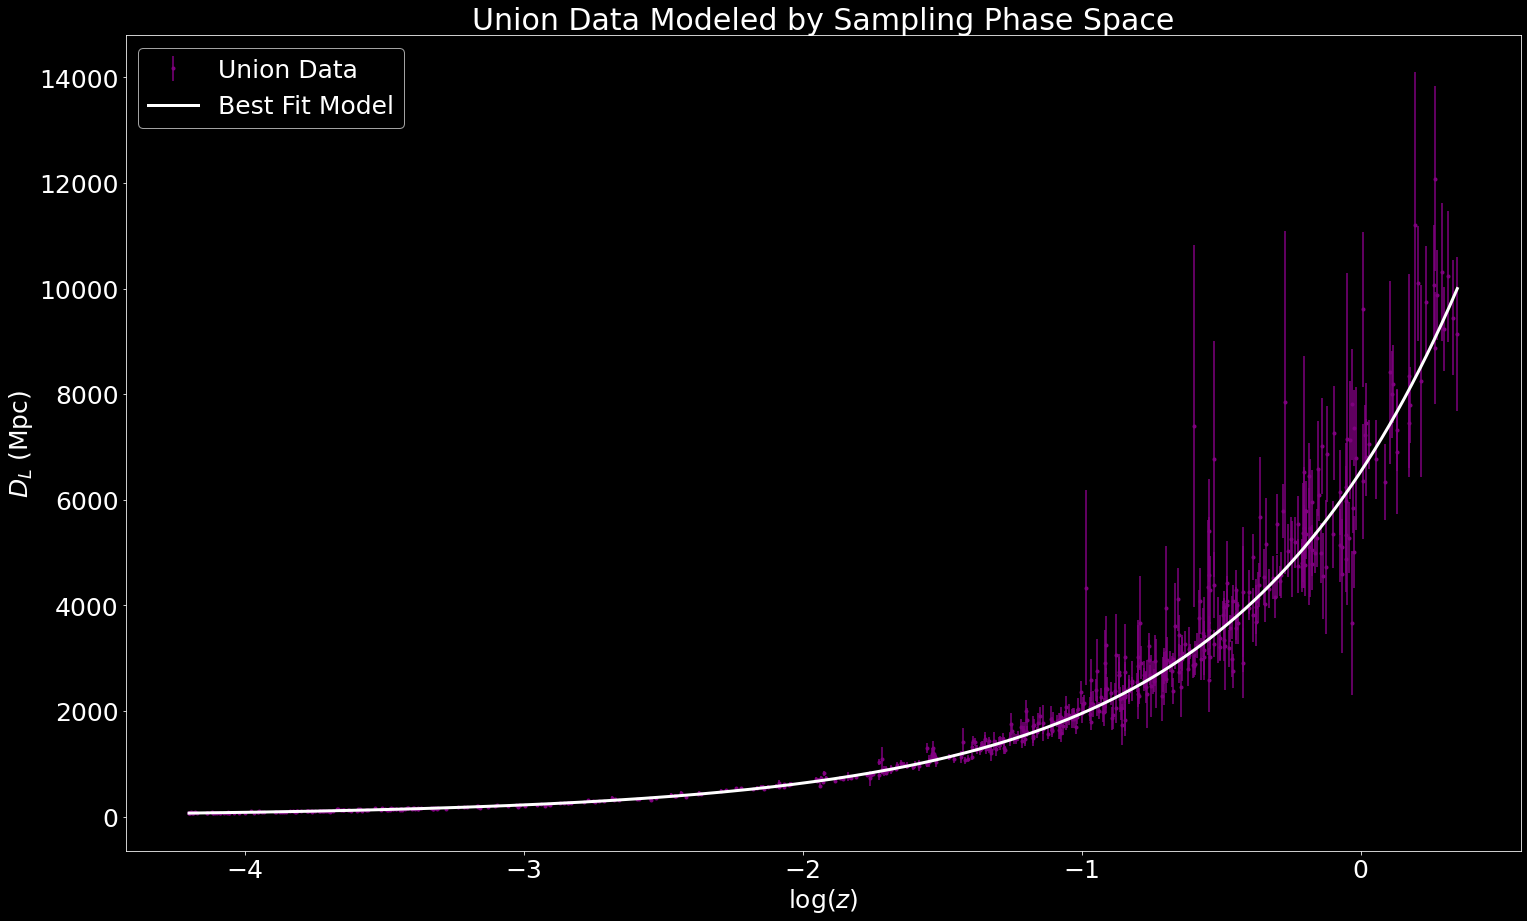

In [148]:
plt.figure(figsize = (25,15))
zz = np.linspace(np.min(redshift),np.max(redshift),1000)
plt.errorbar(np.log(redshift),lum_dist,yerr=lum_dist_err,fmt='.',color='purple')
plt.errorbar(np.log(zz),D_L_helper(zz, omega_m_best, omega_lambda_best, H_0_best), linewidth=3,color='white')
plt.xlabel("$\log(z)$")
plt.ylabel("$D_L$ (Mpc)")
plt.legend(("Union Data","Best Fit Model"),loc='upper left')
plt.title("Union Data Modeled by Sampling Phase Space");

## Scale Factor Integration

## Discussion of Results

## References
Ryden, B. Introduction to Cosmology. Addison Wesley, 2003.

Riess, A. G., et al. 1998, Astron. J., 116, 1009.